# Кластеризация K-средних
автор: [Владимир Сизов](mailto:vladimirsizov@yandex.ru)

Кластеризация K-средних распространённый алгоритм неконтролируемого машинного обучения.  
Определение кластеров осуществляется на схожести данных у экземпляров. 

Ниже мы подробно рассмотрим метод подбора координат центройдов, разделения данных на кластеры, а также нарисуем результат на графике.

<hr>

Для работы этого алгоритма необходимо заранее определить количество кластеров.  

Импортируем необходимые библиотеки

In [134]:
import pandas as pd
import numpy as np

import seaborn as sns
sns.set(style='whitegrid', rc={'figure.figsize': (7, 7)})

При использовании этого алгоритма данные для кластеризации можно задавать в формате: \[x, y, z, ...\] 

В качестве примера мы сгенерируем двумерный массив \[x, y\]

In [135]:
np.random.seed(17)

x = [4, 6, 10, 13]
y = [3, 9, 14, 10]

cluster_x = []
cluster_y = []

for i in zip(x, y):
    cluster_x.append(np.random.normal(i[0], 1, 40))
    cluster_y.append(np.random.normal(i[1], 1.4, 40))

x = np.concatenate(cluster_x)
y = np.concatenate(cluster_y)

df = pd.DataFrame([i for i in zip(x, y)], columns=['x', 'y'])
df.head()

,x,y
0,4.276266,1.382421
1,2.145372,7.683220
2,4.623901,3.177418
3,5.145311,2.028150
4,5.037190,3.780744


Посмотрим как данные выглядят на графике:

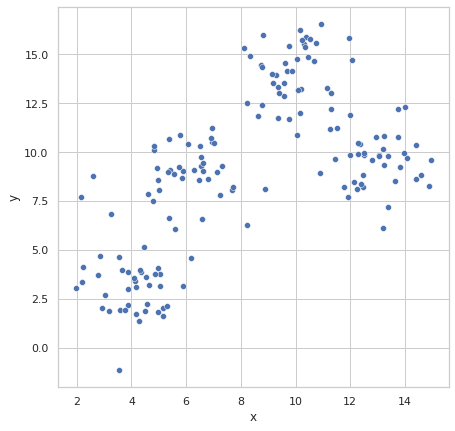

In [136]:
sns.scatterplot(data=df, x='x', y='y');

<hr>

Алгоритм кластеризации clusterization() выглядит следующим образом:  
Мы принимаем параметры df (с массивами значений x, y), а также clusters - число кластеров которые мы будем искать.  
Также мы сообщаем, хотим ли мы добавить в данные координаты центройдов add_centroid=True

Создаём список названия осей координат.  

Функция first_centroid() принимает данные координат и возвращает случайные первичные значения центройдов, а также список с их именами. 

Далее идет сам цикл подбора центройдов и определения кластера для каждой координаты while:  
Мы сохраняем последнее значение centroids в current_centroids, для последующего сравнения. 

С помощью функции cluster_update() мы получаем датафрейм, который включает:  
\- координаты  
\- Евклидово расстояние от координат до каждого центройда  
\- названием ближайшего кластера к которому определены координаты для каждой точки  

С помощью функции means_clusters() мы получаем новые координаты для центройдов

<hr>

Каждый кластер определяется центройдом и наиболее близко расположенным к нему облаку точек.  

По сути алгоритм заключается в том что центройды должны поделить все точки между собой таким образом, чтобы повторная итерация цикла while не давала изменения в переопределении значений координат центройдов - в этом случае это будет означать что кластеры определены и цикл должен прерваться.

Если мы хотим чтобы в наши данные добавили центройды - это сделает функция add_centroids() 

Функция clusterization() возвращает датафрейм с координатами и названием кластера для каждой координаты.

In [137]:
def clusterization(df, clusters, add_centroid=False): 
    axis = df.columns.to_list()
    # определяем первые значения центройдов
    centroids = first_centroid(df, clusters)[0]
    cnames = first_centroid(df, clusters)[1]
    while True:
        # считаем евклидово расстояние до центройдов
        current_centroids = centroids.copy()
        clustered = cluster_update(df, current_centroids, axis)
        # получаем средние значения кластеров
        centroids = means_clusters(clustered, cnames)
        if centroids == current_centroids:
            break
    if add_centroid == True:
        clustered = add_centroids(centroids, clustered)
    return clustered

Ниже рассмотрим каждую функцию по отдельности.  
<hr>
Функция first_centroid() по сути возврщает первые попавшиеся координаты, это не пренципильно потому, что в процессе переопределения координат центройдов они в любом случае изменятся.  

В качестве примера мы судем строить три кластера, соответственно для начала попросим приготовить координаты трёх центройдов

In [138]:
def first_centroid(df, clusters):
    axis = df.columns.to_list()
    centroids = []
    cnames = []
    for c in range(clusters):
        cname = 'C' + str(c+1)
        centroid = []
        for a in range(len(axis)):
            centroid.append(df.loc[c][axis[a]])
        centroids.append([cname, centroid])
        cnames.append(cname)
    return [centroids, cnames]


centroids = first_centroid(df, 3)[0]
cnames = first_centroid(df, 3)[1]

centroids, cnames

([['C1', [4.276265890021318, 1.382421387245445]],
  ['C2', [2.1453719211934947, 7.68322035286412]],
  ['C3', [4.623901111326356, 3.17741809574377]]],
 ['C1', 'C2', 'C3'])

В ответе под индексом \[0\] мы получаем координаты центройдов, под индексом \[1\] их имена.  

<hr>

Функция cluster_update() перебирает датафрейм по строкам. 

В процессе обработки новые данные для каждой строки постепенно добавляются в словарь new_row, а в конце перебора дополненый датафрейм построчно собирается заново.  
\- переменная row хранит координаты, их мы добавляем в первую очередь  
\- затем мы определяем Евклидово расстояние от координаты до центройда, мы это делаем для каждого центройда по очереди, по формуле:  

<img src='https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSv1ymHbY7ecuBOJMQzckZIkfKfOLgTvt3IJg&usqp=CAU' width=320, heigth=240>

попутно каждое Евклидово расстояние мы аккуратно складываем в словарь clusters, для того чтобы когда мы соберём все расстояния до кластеров для каждой координаты - мы сравним их и через функцию get_cluster() определим самое меньшее тем самым указав в столбце clusters имя кластера к которому она пренадлежит.

In [139]:
def cluster_update(df, centroids, axis):
    # добавляем евклидово расстояние до центройдов
    data = []
    for r in range(len(df)):
        row = df.loc[r]
        new_row = {}
        # добавляем оси
        for a in range(len(row)):
            new_row[row.index[a]] = row[a]
        data.append(new_row)
        # добавляем евклидово расстояние до каждого кластера
        clusters = {}
        for c in range(len(centroids)):
            name_centroid = centroids[c][0]
            result = []
            for a in range(len(row)):
                diff = row[a] - centroids[c][1][a]
                result.append(diff)
            euclid = sum(np.array(result)**2)**0.5
            # добавляем центройды
            new_row[name_centroid] = euclid
            clusters[name_centroid] = euclid
        # подбираем текущий кластер
        new_row['cluster'] = get_cluster(clusters)
    return pd.DataFrame(data)


axis = df.columns.to_list()

print('\nтаблица выгладит так:')
df = cluster_update(df, centroids, axis).head()
df


таблица выгладит так:


,x,y,C1,C2,C3,cluster
0,4.276266,1.382421,0.000000,6.651374,1.828350,C1
1,2.145372,7.683220,6.651374,0.000000,5.142505,C2
2,4.623901,3.177418,1.828350,5.142505,0.000000,C3
3,5.145311,2.028150,1.082684,6.401520,1.262017,C1
4,5.037190,3.780744,2.516140,4.857153,0.731307,C3


<hr>

Собственно функция для определения расстояния.  
Здесь мы построчно сравниваем значения колонок C1, C2 и C3, а в колонку cluster записываем название той колонки значение которой меньшее из всех кластеров, тем самым определяя к какому кластеру пренадлежат координаты каждой строки.

In [140]:
def get_cluster(clusters):
    i = 0
    cluster_name = ''
    cluster_value = 0
    for name, value in clusters.items():
        if i == 0:
            cluster_name = name
            cluster_value = value
            i += 1
        else:
            if value < cluster_value:
                cluster_name = name
                cluster_value = value
    return cluster_name

<hr>
Функция means_clusters() выполняет обработку датафрейма полученного функцией cluster_update.
Суть переопределения новых координат для центройдов достаточно проста:  
Мы группируем данные по колонке cluster, при этом в сагригированных данных для каждого кластера в итоге мы получаем среднее значение каждой координатной оси - это и есть наши новые координаты.

Точка центройда какбы переползает по координатной плоскости ориентируясь на максимальный захват соседних точек, но так как центройдов несколько и у части окружающих точек Евклидово расстояние ближе до какого-то определённого центройда кластеры распределяют точки равномерно.

In [141]:
def means_clusters(df, cnames):
    df.drop(cnames, axis=1, inplace=True)
    axis = df.columns.to_list()
    axis.remove('cluster')
    df = df.groupby('cluster')[axis].agg('mean')
    means = []
    for c in cnames:
        axis_values = []
        for a in axis:
            axis_values.append(df.loc[c][a])
        means.append([c, axis_values])
    return means

means_clusters(df, cnames)

[['C1', [4.710788589796705, 1.7052854661138659]],
 ['C2', [2.1453719211934947, 7.68322035286412]],
 ['C3', [4.830545789777119, 3.4790811494994984]]]

<hr>

Как мы помним, если мы хотим чтобы на графике были также отображены центройды, мы можем пеедать в качестве параметра add_centroid=True к функции clusterization()

Работу по добавлению центройдов выполняет функция add_centroids()
Эта функция получает готовый датафрейм, и дописывает в качестве одного из кластеров с  именем centroids координаты центройдов

In [142]:
def add_centroids(centroids, clustered):
    rows = []
    for c in centroids:
        name_centroid = c[0]
        row = []
        for  coordinate in c[1]:
            row.append(coordinate)
        row.append('centroids')
        clustered.loc[ len(clustered.index )] = row
    return clustered

Всё вместе это выглядит так:

In [143]:
def first_centroid(df, clusters):
    axis = df.columns.to_list()
    centroids = []
    cnames = []
    for c in range(clusters):
        cname = 'C' + str(c+1)
        centroid = []
        for a in range(len(axis)):
            centroid.append(df.loc[c][axis[a]])
        centroids.append([cname, centroid])
        cnames.append(cname)
    return [centroids, cnames]


def get_cluster(clusters):
    i = 0
    cluster_name = ''
    cluster_value = 0
    for name, value in clusters.items():
        if i == 0:
            cluster_name = name
            cluster_value = value
            i += 1
        else:
            if value < cluster_value:
                cluster_name = name
                cluster_value = value
    return cluster_name


def cluster_update(df, centroids, axis):
    # добавляем евклидово расстояние до центройдов
    data = []
    for r in range(len(df)):
        row = df.loc[r]
        new_row = {}
        # добавляем оси
        for a in range(len(row)):
            new_row[row.index[a]] = row[a]
        data.append(new_row)
        # добавляем евклидово расстояние до каждого кластера
        clusters = {}
        for c in range(len(centroids)):
            name_centroid = centroids[c][0]
            result = []
            for a in range(len(row)):
                diff = row[a] - centroids[c][1][a]
                result.append(diff)
            euclid = sum(np.array(result)**2)**0.5
            # добавляем центройды
            new_row[name_centroid] = euclid
            clusters[name_centroid] = euclid
        # подбираем текущий кластер
        new_row['cluster'] = get_cluster(clusters)
    return pd.DataFrame(data)


def means_clusters(df, cnames):
    df.drop(cnames, axis=1, inplace=True)
    axis = df.columns.to_list()
    axis.remove('cluster')
    df = df.groupby('cluster')[axis].agg('mean')
    means = []
    for c in cnames:
        axis_values = []
        for a in axis:
            axis_values.append(df.loc[c][a])
        means.append([c, axis_values])
    return means


def add_centroids(centroids, clustered):
    rows = []
    for c in centroids:
        name_centroid = c[0]
        row = []
        for  coordinate in c[1]:
            row.append(coordinate)
        row.append('centroids')
        clustered.loc[ len(clustered.index )] = row
    return clustered

    
def clusterization(df, clusters, add_centroid=False): 
    axis = df.columns.to_list()
    # определяем первые значения центройдов
    centroids = first_centroid(df, clusters)[0]
    cnames = first_centroid(df, clusters)[1]
    while True:
        # считаем евклидово расстояние до центройдов
        current_centroids = centroids.copy()
        clustered = cluster_update(df, current_centroids, axis)
        # получаем средние значения кластеров
        centroids = means_clusters(clustered, cnames)
        if centroids == current_centroids:
            break
    if add_centroid == True:
        clustered = add_centroids(centroids, clustered)
    return clustered

Мы вызовем функцию clusterization() и попросим разделить координаты на 3 кластера

In [144]:
df = pd.DataFrame([i for i in zip(x, y)], columns=['x', 'y'])
data = clusterization(df, 3, add_centroid=True)

data.tail(10)

,x,y,cluster
153,13.975275,9.976784,C3
154,13.738482,10.759248,C3
155,11.460976,9.620952,C3
156,12.385329,8.378493,C3
157,13.208148,10.178403,C3
158,12.812098,9.580945,C3
159,12.136830,8.458143,C3
160,4.699489,5.021778,centroids
161,8.932836,13.029020,centroids
162,12.855044,9.540528,centroids


На выходе мы получаем кластеризованый датафрейм.
Теперь скаттерплот нарисует разным цветом наши кластеры.

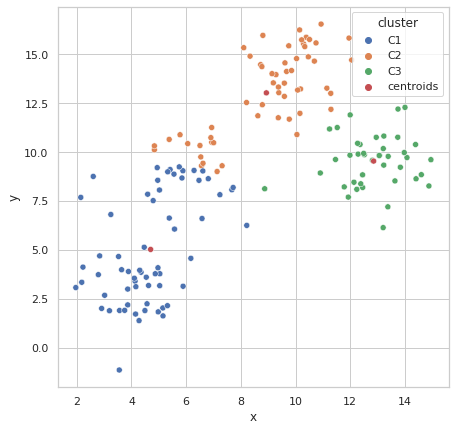

In [145]:
sns.scatterplot(data=data, x='x', y='y', hue='cluster');